In [1]:
import numpy as np
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet

%matplotlib inline

Note on installation
---
To incorporated with pystan-2.17, we require to install Phophet 0.2+. 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%load_ext watermark

In [5]:
%watermark -a "" -v -p numpy,scipy,matplotlib,seaborn,pandas,qgrid,pystan,statsmodels,fbprophet,folium

CPython 3.6.1
IPython 6.2.1

numpy 1.13.3
scipy 1.0.0
matplotlib 2.1.0
seaborn 0.8.1
pandas 0.21.0
qgrid 1.0.0b5
pystan 2.17.0.0
statsmodels 0.8.0
fbprophet 0.2.1
folium 0.5.0


In [6]:
air_visit_data = pd.read_csv("data/air_visit_data.csv")

In [8]:
air_visit_data.tail(5)

,air_store_id,visit_date,visitors
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8
252107,air_24e8414b9b07decb,2017-04-22,5


Accumulation numbers of Visitors
---
Native data collected came from different store ( air_store_id) but possibly at the same date. Thus we make a simple 
computation to accumulate data  at the same date.

In [7]:
air_visit_data_group = air_visit_data.groupby('visit_date');
air_visit_data_totals = air_visit_data_group.sum()

In [8]:
air_visit_data_totals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478 entries, 2016-01-01 to 2017-04-22
Data columns (total 1 columns):
visitors    478 non-null int64
dtypes: int64(1)
memory usage: 7.5+ KB


Question
---
The picture below shows the quantity of data varied at the end of 5 weeks. What info could you expect at first glance?
1. <font style="background-color:yellow;color:yellow;font-size:1.5em;">
there are 5 peaks during the time periods consider here;
</font><br>
<font style="background-color:yellow;color:yellow;font-size:1.5em;">
2. time periods between consective peaks are almost equal.    
</font>

<b>Conclusion</b><br> 
<p>
<font style="background-color:yellow;color:yellow;font-size:2em;">
    Period should be considered!
</font>    

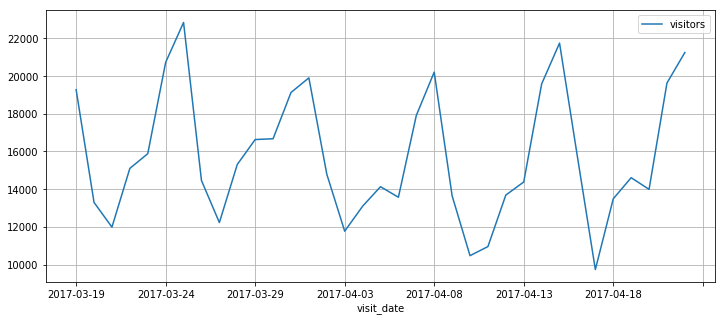

In [9]:
air_visit_data_totals[-35:].plot(figsize=[12,5],grid=True)

In [10]:
air_visit_data_totals.to_csv("data/air_visit_data_totals.csv")

In [10]:
air_visit_data = pd.read_csv("data/air_visit_data_totals.csv")

In [11]:
air_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 2 columns):
visit_date    478 non-null object
visitors      478 non-null int64
dtypes: int64(1), object(1)
memory usage: 7.5+ KB


In [12]:
air_visit_data.columns=['ds','y']

In [13]:
air_visit_data.head()

,ds,y
0,2016-01-01,1033
1,2016-01-02,1764
2,2016-01-03,2368
3,2016-01-04,3326
4,2016-01-05,3927


To make future prediction by help of <b style="font-face:bold;font-size:1.2em;color:brown;">fbprophet</b>, we have to prepare date with the columns with the pair of <b style="font-face:bold;font-size:1.2em;color:red;">['ds','y']</b>: one is the date format and the other is quantity. 

To suit for fbprophet requirement, dataframe could be purged other columns by the following operation:
<code>
  data=air_visit_data.drop('air_store_id', axis=1)
  data.columns=['ds','y']  
</code>   

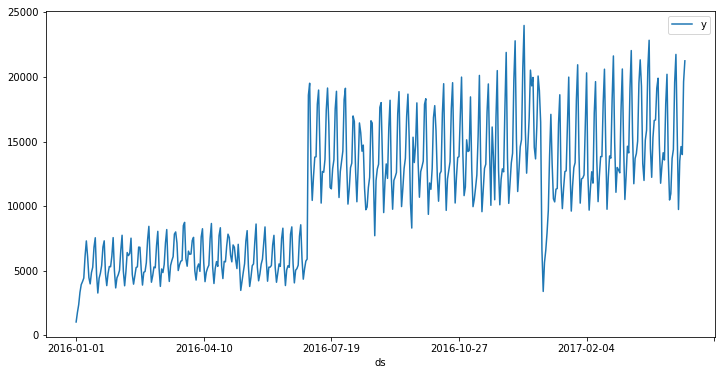

In [15]:
air_visit_data.set_index('ds').plot(figsize=(12, 6))  

Let's prophet on the data:
<pre>
  # claim the prophet functio  
  m = Prophet()
  # fit data  
  m.fit(data)
  # days: the time period wants to be predicted  
  future = m.make_future_dataframe(periods=days)
  # finally predict data in the future  
  forecast = m.predict(future)  
</pre>    

In [16]:
m = Prophet()  
m.fit(air_visit_data)  

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
# predict the last 30 data:
future_data = m.make_future_dataframe(periods=30)  
future_data.tail() 

,ds
503,2017-05-18
504,2017-05-19
505,2017-05-20
506,2017-05-21
507,2017-05-22


That gives us a data frame with dates going thirty days (<font color="brown">30</font>) forward from where our data ends. We can then use the "predict" function to populate this data frame with forecast information.

In [18]:
forecast = m.predict(future_data)  

In [19]:
# the last 30 records what we have predict 
forecast1=forecast['yhat'].tail(30) 
forecast1

478    15028.146650
479    12486.726466
480    13828.125938
481    14863.203698
482    15011.340168
483    18016.871342
484    19481.623468
485    15088.565253
486    12547.145069
487    13888.544542
488    14923.622301
489    15071.758771
490    18077.289945
491    19542.042071
492    15148.983857
493    12607.563673
494    13948.963145
495    14984.040905
496    15132.177375
497    18137.708549
498    19602.460675
499    15209.402461
500    12667.982276
501    14009.381749
502    15044.459508
503    15192.595978
504    18198.127152
505    19662.879278
506    15269.821064
507    12728.400880
Name: yhat, dtype: float64

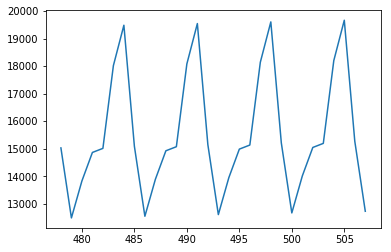

In [20]:
# visualize the last 30 records
forecast['yhat'].tail(30).plot()

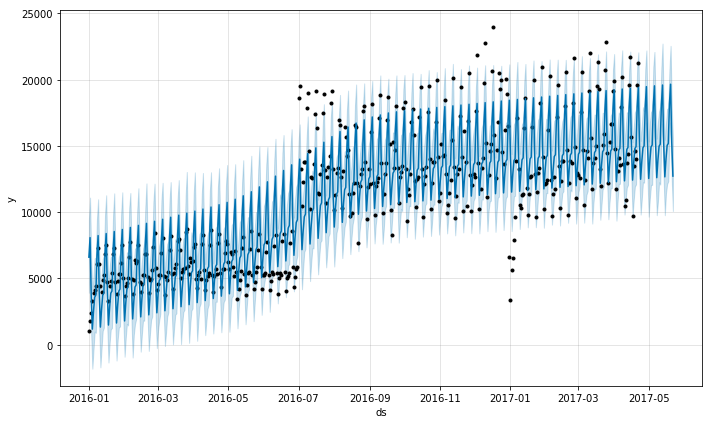

In [21]:
m.plot(forecast);  

We can use another built-in plot to show each of the individual components. This is quite useful to visually inspect what the model is capturing from the data. In this case there are a few clear takeaways such as higher viviting during  on Friday and Saturday.

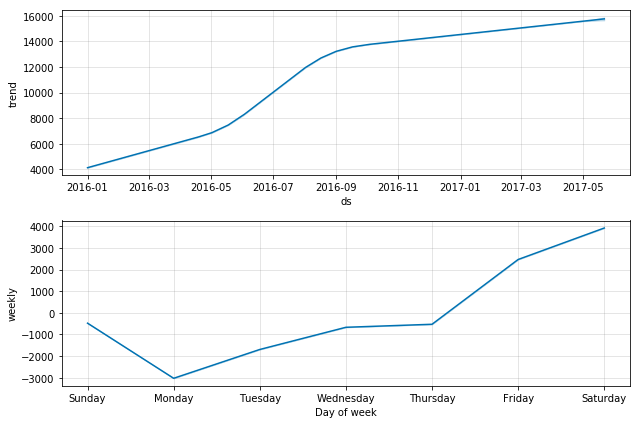

In [22]:
m.plot_components(forecast);  

Holiday Effect
---
In addition to the above components, Prophet can also incorporate possible effects from holidays. Holidays and dates for each holiday have to be manually specified over the entire range of the data set (including the forecast period). The way holidays get defined and incorporated into the model is fairly simple. 

Below are some holiday definitions for our current data set that include Peyton Manning's playoff and Superbowl appearances (taken from the example code).

In [23]:
# load holidays info
day_info= pd.read_csv("data/date_info.csv")

In [24]:
day_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [25]:
days=day_info[day_info['holiday_flg']==1]['calendar_date']

In [26]:
days.values

array(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-11',
       '2016-02-11', '2016-03-20', '2016-03-21', '2016-04-29',
       '2016-05-03', '2016-05-04', '2016-05-05', '2016-07-18',
       '2016-08-11', '2016-08-13', '2016-08-14', '2016-08-15',
       '2016-09-19', '2016-09-22', '2016-10-10', '2016-11-03',
       '2016-11-23', '2016-12-23', '2016-12-29', '2016-12-30',
       '2016-12-31', '2017-01-01', '2017-01-02', '2017-01-03',
       '2017-01-09', '2017-02-11', '2017-03-20', '2017-04-29',
       '2017-05-03', '2017-05-04', '2017-05-05'], dtype=object)

In [27]:
holidays = pd.DataFrame({  
  'holiday': 'holiday',
  'ds': pd.to_datetime(days.values),
  'lower_window': 0,
  'upper_window': 1,
})


In [28]:
m2 = Prophet(holidays=holidays)  
m2.fit(air_visit_data)  

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
# predict the last 30 data:
future_data2 = m2.make_future_dataframe(periods=30)  
future_data2.tail() 

,ds
503,2017-05-18
504,2017-05-19
505,2017-05-20
506,2017-05-21
507,2017-05-22


In [30]:
forecast2 = m2.predict(future_data2)  

In [31]:
# what we have predict 
forecast230=forecast2['yhat'].tail(30) 

In [32]:
dt=forecast['ds'].tail(30) 

In [33]:
from numpy import log

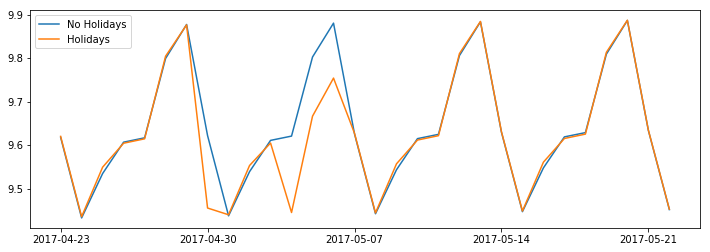

In [34]:
plt.figure(figsize=(12,4))
plt.plot(dt,log(forecast1),label='No Holidays')
plt.plot(dt,log(forecast230),label='Holidays')
plt.legend()

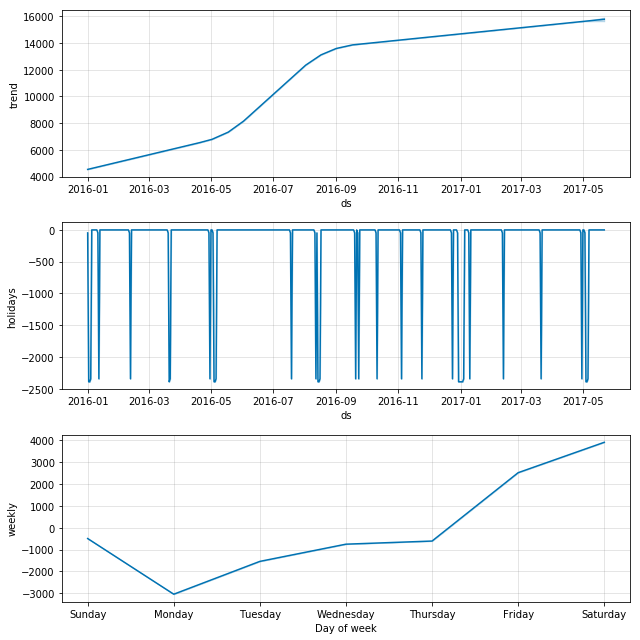

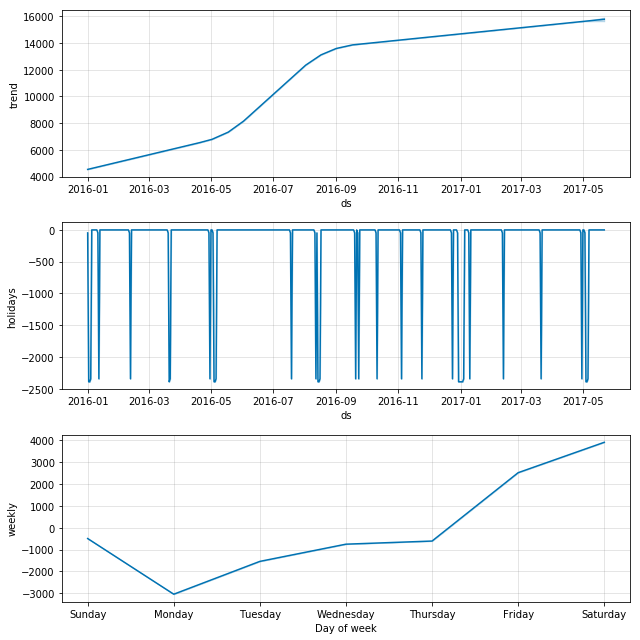

In [35]:
m2.plot_components(forecast2)

Our component plot now includes a holidays component with spikes indicating the magnitude of influence those holidays have on the value.

While the Prophet library itself is very powerful, there are some useful features that we'd typically want when doing time series modeling that it currently doesn't provide. One very simple and obvious thing that's needed is a way to evaluate the forecasts. We can do this ourselves using scikit-learn's metrics.

In [36]:
from sklearn.metrics import mean_absolute_error  
forecast2 = m2.predict(future_data2)  
mean_absolute_error(air_visit_data['y'], forecast2[:-30]['yhat'])  

1555.8131747361504

In [51]:
# Although prediction we want to find, it is not really reasonable: the fourth record of visitors is negative!

In [50]:
test=forecast2[:-30]['yhat']
test[:5]

0    7013.667284
1    6079.535000
2    1696.433022
3    -784.758652
4    3076.252310
Name: yhat, dtype: float64

Here, two metrics are available, one is based on general sum of sequence, and the other is the sum by algorithm of vectorization; obviously, the latter is faster than the forth: 

In [48]:
def RMSLE(y,yhat):
    Sum=0

    for i in range(len(y)):
        yhat[yhat<0]=0
        Sum+=(log(y[i]+1)-log(yhat[i]+1))**2
    return np.sqrt(Sum/len(y))    

In [46]:
def RMSLE_vec(y,yhat):
    Sum=0
    yhat[yhat<0]=0
    Sum=np.sum((log(y+1)-log(yhat+1))**2)
    
    return np.sqrt(Sum/len(y))    

In [49]:
RMSLE(air_visit_data['y'], forecast2[:-30]['yhat'])


0.46312741798729251

In [47]:
RMSLE_vec(air_visit_data['y'], forecast2[:-30]['yhat'])


0.46312741798729257

In [53]:
air_data = pd.read_csv("data/air_store_info.csv")

In [54]:
air_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [56]:
lat_mean=air_data['latitude'].mean()
lat_mean

35.647042153196644

In [58]:
lon_mean=air_data['longitude'].mean()
lon_mean

137.4153107495778

In [37]:
import folium
#from folium.element import IFrame


In [59]:


# the coordinates of center at the means of (latitues,longitude)
JP_COORDINATES = (lat_mean,lon_mean)

# for speed purposes
MAX_RECORDS = 1000
 
# create empty map zoomed in on San Francisco
map = folium.Map(location=JP_COORDINATES, zoom_start=12)
lons=[]
lats=[]
d=[]
# add a marker for every record in the filtered data, use a clustered view
for each in air_data[0:MAX_RECORDS].iterrows():
    # get (lat,lon) array and details array
    lat = each[1]['latitude']
    lon = each[1]['longitude'] 
    d_title = each[1]['air_store_id']
    
    #emerage the data
    d.append(d_title)
    lats.append(lat)
    lons.append(lon)
    locations = list(zip(lats, lons))
# make final map    
map.add_children(MarkerCluster(locations = locations,popups=d))
display(map)

To accerate the running speed, emerage locations could be replaced by
<pre style="font-family:georgia;font-size:1.2em;">
X=air_data['latitude']
Y=air_data['longitude']
locations=list(zip(X,Y))
</pre>

In [61]:
# the coordinates of center at the means of (latitues,longitude)
JP_COORDINATES = (lat_mean,lon_mean)

 
# create empty map zoomed in on San Francisco
map = folium.Map(location=JP_COORDINATES, zoom_start=12)
lons=[]
lats=[]
d=[]
# add a marker for every record in the filtered data, use a clustered view
X=air_data['latitude']
Y=air_data['longitude']
locations=list(zip(X,Y))
d = air_data['air_store_id']

# make final map    
map.add_children(MarkerCluster(locations = locations,popups=d))
display(map)

In [63]:
import os
map.save(os.path.join('data', 'air_visitors.html'))